# 100 Years of Baseball

### Imports

In [1]:
import numpy as np
import pandas as pd
import os

/var/folders/6s/gfdfmtws7z3_vh932bxspdnw0000gn/T/ipykernel_68563/2443873611.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Data Loading

In [2]:
data_dir = './data'

Unfortunately, the original dataset I planned to work with was improperly assembled from the raw csv files, resulting in many missing rows. I still like the column names, so we will use those from that csv, but we will build the DataFrame from scratch using the individual year game log files. 

In [4]:
col_names = pd.read_csv(os.path.join(data_dir, 'game_logs.csv'), nrows=0).columns
col_names

Index(['date', 'number_of_game', 'day_of_week', 'v_name', 'v_league',
       'v_game_number', 'h_name', 'h_league', 'h_game_number', 'v_score',
       ...
       'h_player_7_name', 'h_player_7_def_pos', 'h_player_8_id',
       'h_player_8_name', 'h_player_8_def_pos', 'h_player_9_id',
       'h_player_9_name', 'h_player_9_def_pos', 'additional_info',
       'acquisition_info'],
      dtype='object', length=161)

In [5]:
data_raw = pd.DataFrame()

for year in range(1871, 2024):
    year_df = pd.read_csv(f"./data/gl1871_2023/gl{str(year)}.txt", header=None)
    data_raw = pd.concat([data_raw, year_df])
    
del year_df

data_raw.columns = col_names

In [6]:
data_raw.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 228779 entries, 0 to 2429
Columns: 161 entries, date to acquisition_info
dtypes: float64(77), int64(6), object(78)
memory usage: 1.2 GB


## Memory Management and Column dtypes
This object is manageable in size (~1.2GB), but we would like to reduce it. We could optimize some of our numerical columns, but we will get much more memory optimization from converting our `object` columns to `categorical`. 

The memory usage of a `Categorical` is proportional to the number of categories plus the length of the data. In contrast, an `object` dtype is a constant times the length of the data - [Pandas Documentation](https://pandas.pydata.org/docs/user_guide/categorical.html#categorical-memory). Because of this, we will use use the categorical dtype only when the number of unique values is significantly smaller than the number of total values. 

In addition to this, we need to consider whether a categorical datatype makes sense for the data in each column as well as the limitations of the pandas categorical type. Mainly, categorical columns are not compatible with numpy, so we will have to take that into account. 

Here are our `object` columns:

In [7]:
pd.set_option('display.max_columns', 100)
data_obj = data_raw.select_dtypes(include=["object"]).copy()
data_obj.describe()

,day_of_week,v_name,v_league,h_name,h_league,day_night,completion,forefeit,protest,park_id,v_line_score,h_line_score,hp_umpire_id,hp_umpire_name,1b_umpire_id,1b_umpire_name,2b_umpire_id,2b_umpire_name,3b_umpire_id,3b_umpire_name,lf_umpire_id,lf_umpire_name,rf_umpire_id,rf_umpire_name,v_manager_id,v_manager_name,h_manager_id,h_manager_name,winning_pitcher_id,winning_pitcher_name,losing_pitcher_id,losing_pitcher_name,saving_pitcher_id,saving_pitcher_name,winning_rbi_batter_id,winning_rbi_batter_id_name,v_starting_pitcher_id,v_starting_pitcher_name,h_starting_pitcher_id,h_starting_pitcher_name,v_player_1_id,v_player_1_name,v_player_2_id,v_player_2_name,v_player_3_id,v_player_3_name,v_player_4_id,v_player_4_name,v_player_5_id,v_player_5_name,v_player_6_id,v_player_6_name,v_player_7_id,v_player_7_name,v_player_8_id,v_player_8_name,v_player_9_id,v_player_9_name,h_player_1_id,h_player_1_name,h_player_2_id,h_player_2_name,h_player_3_id,h_player_3_name,h_player_4_id,h_player_4_name,h_player_5_id,h_player_5_name,h_player_6_id,h_player_6_name,h_player_7_id,h_player_7_name,h_player_8_id,h_player_8_name,h_player_9_id,h_player_9_name,additional_info,acquisition_info
count,228779,228779,227698,228779,227698,208491,189,149,273,228779,210201,210201,228763,228766,203923,228766,144687,228143,173593,228143,208,228769,14,228769,228779,228779,228779,228779,207660,207660,207660,207660,74829,208482,176417,208482,228735,228735,228735,228735,208482,208482,208482,208482,208482,208482,208482,208482,208482,208482,208482,208482,208482,208482,208482,208482,208479,208479,208482,208482,208482,208482,208482,208482,208482,208482,208482,208482,208482,208482,208482,208482,208482,208482,208482,208482,1808,228779
unique,7,150,6,150,6,2,189,3,5,258,50745,47811,1346,1340,894,893,555,556,608,608,36,37,13,14,727,727,740,740,6870,6806,7536,7460,4283,4263,7829,7717,6365,6313,6318,6276,3847,3806,4831,4767,3939,3904,3485,3458,4978,4924,6258,6168,6912,6821,6523,6444,7800,7708,3764,3727,4727,4667,3800,3768,3421,3398,4916,4863,6245,6159,6859,6773,6412,6330,7224,7146,597,4
top,Sat,CHN,NL,CHN,NL,D,"19190727,,0,2,36",H,V,BOS07,000000000,000000000,klemb901,Bill Klem,connt901,(none),westj901,(none),westj901,(none),sudoe901,(none),gormt101,(none),mackc101,Connie Mack,mackc101,Connie Mack,johnw102,Walter Johnson,ryann001,Dutch Leonard,rivem002,(none),pujoa001,(none),younc102,Don Sutton,younc102,Nolan Ryan,hendr001,Rickey Henderson,fox-n101,Nellie Fox,speat101,Tris Speaker,murre001,Eddie Murray,heilh101,Harry Heilmann,grimc101,Charlie Grimm,doolm101,Mickey Doolin,lopea102,Al Lopez,guilo001,Ozzie Guillen,hendr001,Rickey Henderson,fox-n101,Nellie Fox,speat101,Tris Speaker,murre001,Eddie Murray,heilh101,Harry Heilmann,grimc101,Charlie Grimm,doolm101,Mickey Doolin,lopea102,Al Lopez,guilo001,Ozzie Guillen,HTBF,Y
freq,38137,10961,116993,11132,117005,114377,1,70,134,8771,12135,11588,3544,3544,2025,24843,1326,83456,1398,54550,30,228561,2,228755,3898,3898,3846,3846,417,417,292,295,652,133653,328,32065,403,375,412,412,1447,1447,852,852,1312,1312,1005,1005,665,665,465,465,719,719,687,687,547,547,1428,1428,859,859,1245,1245,1033,1033,612,612,427,427,686,686,676,676,548,548,1178,181379


Some columns are obvious candidates for the categorical dtype, such as `day_of_week` and `day_night`. Thinking about the content of these columns, the `v_line_score` and `h_line_score` columns stick out, as they represent the box score (runs scored in each inning by both teams). It doesn't make much sense to represent these as categorical data. I will not make extensive use of them in this analysis, but if using them, it would be best to either create a custom dtype for this data or to represent the score for each inning as its own column in the DataFrame. 

The big question mark is our player name data. The ratio of unique values to total length for these columns is about 0.03, and there are a lot of columns representating player name and id, so we will see large memory savings by converting these columns. However, we will make extensive use of these columns in network analysis, so it may be easier to work with them as object columns. For now, we will convert them to categorical. 

In [8]:
data_obj.drop(columns=['v_line_score', 'h_line_score'], inplace=True)   # Drop v_line and h_line columns
data_obj = data_obj.astype('category')                                  # Convert remaining columns to categorical 

In [9]:
data_opt = data_raw.copy()
data_opt[data_obj.columns] = data_obj
del data_obj                                                            # data_obj no longer needed

In [10]:
print('Optimized DataFrame')
print(data_opt.info(memory_usage='deep'))
print('\nOriginal DataFrame')
print(data_raw.info(memory_usage='deep'))

Optimized DataFrame
<class 'pandas.core.frame.DataFrame'>
Index: 228779 entries, 0 to 2429
Columns: 161 entries, date to acquisition_info
dtypes: category(76), float64(77), int64(6), object(2)
memory usage: 231.1 MB
None

Original DataFrame
<class 'pandas.core.frame.DataFrame'>
Index: 228779 entries, 0 to 2429
Columns: 161 entries, date to acquisition_info
dtypes: float64(77), int64(6), object(78)
memory usage: 1.2 GB
None


We now have an optimized dataframe where all but 2 of our object columns have been converted to categorical dtypes. Our optimized dataframe takes up 5 times less space with this change!

The last step in cleaning our columns is our date column. This is not a memory saving measure, but we will want to convert our date to a more usable format. Luckily, Pandas gives us a tool for this, the `datetime` type. 

In [11]:
date_col = data_opt['date']
data_opt['date'] = pd.to_datetime(date_col, format="%Y%m%d")
data_opt.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 228779 entries, 0 to 2429
Columns: 161 entries, date to acquisition_info
dtypes: category(76), datetime64[ns](1), float64(77), int64(5), object(2)
memory usage: 231.1 MB


In [12]:
# Save copies of our cleaned data so we do not have to build dataset again. 
data_opt.to_pickle(os.path.join(data_dir, 'data_opt.pkl'))
data_opt.to_csv(os.path.join(data_dir, 'data_opt.csv'), index=False)

In [3]:
data_opt = pd.read_pickle(os.path.join(data_dir, 'data_opt.pkl'))
data_opt.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 228779 entries, 0 to 2429
Columns: 161 entries, date to acquisition_info
dtypes: category(76), datetime64[ns](1), float64(77), int64(5), object(2)
memory usage: 222.1 MB


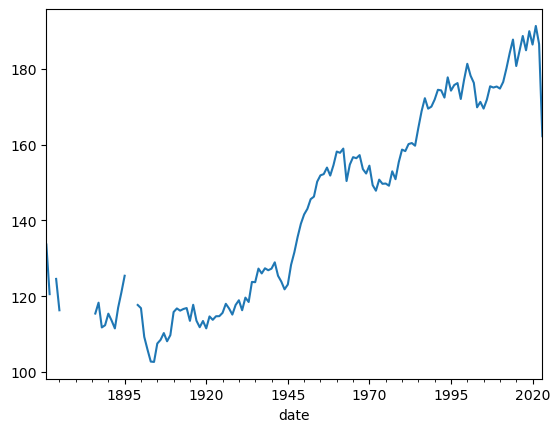

In [29]:
data_opt[data_opt['date'].dt.year > 1870].groupby(pd.Grouper(key='date', freq='YE', axis=0))['length_minutes'].mean().plot(x='date', y='length_minutes');